## Demo: Backpropagation

*Fraida Fund*

In this demo, we will show how to use backpropagation to train a simple neural network for regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

### Generate data

For this demo, we will use synthetic data which relates an individual’s income to the number of years of education they have, and their seniority in their position.

The data is from “An Introduction to Statistical Learning, with applications in R” (Springer, 2013) by G. James, D. Witten, T. Hastie and R. Tibshirani.

In [2]:
df = pd.read_csv('https://www.statlearning.com/s/Income2.csv', index_col=0)
df.head()

,Education,Seniority,Income
1,21.586207,113.103448,99.917173
2,18.275862,119.310345,92.579135
3,12.068966,100.689655,34.678727
4,17.034483,187.586207,78.702806
5,19.931034,20.000000,68.009922


In [3]:
X = np.vstack((df['Education'], df['Seniority'])).T
y = df['Income']
y = np.resize(y, (30,1))

In [4]:
print(X.shape)
print(y.shape)

(30, 2)
(30, 1)


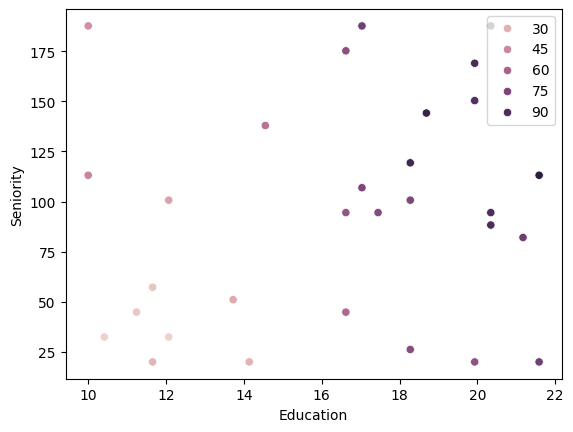

In [5]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y.ravel())
plt.xlabel("Education");
plt.ylabel("Seniority");

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [7]:
# make numbers small so they are easier to work with
x1_max = np.amax(abs(X_train[:,0]))
x2_max = np.amax(abs(X_train[:,1]))
y_max = np.amax(abs(y_train))

X_train[:,0] = X_train[:,0]/x1_max
X_train[:,1] = X_train[:,1]/x2_max
y_train = y_train/y_max

X_test[:,0] = X_test[:,0]/x1_max
X_test[:,1] = X_test[:,1]/x2_max
y_test = (y_test)/y_max

### Construct a network

Now, we will construct a neural network for this dataset.

#### Structure of the network

First, we will describe the structure of the network, and draw it. We have a *regression* problem with

-   Number of inputs: $N_I = 2$
-   Number of outputs: $N_O = 1$
-   Number of training samples $N=15$

and we will use a single hidden layer with three hidden units, $N_H=3$.

In [8]:
inputLayerSize  = X.shape[1]
outputLayerSize = y.shape[1]
hiddenLayerSize = 3

#### Drawing the network

We can use the `networkx` library in Python to draw the network.

In [9]:
import networkx as nx

nodePos = {}
G=nx.Graph()
graphHeight = max(inputLayerSize, outputLayerSize, hiddenLayerSize)

# create nodes and note their positions
for n in range(inputLayerSize):
  nodePos['x'+str(n+1)]=(1, n)
  G.add_node('x'+str(n+1))
for n in range(outputLayerSize):
  nodePos['o'+str(n+1)]=(5, n)
  G.add_node('o'+str(n+1))
for n in range(hiddenLayerSize):
  nodePos['h'+str(n+1)]=(3, n)
  G.add_node('h'+str(n+1))

# add edges
for n in range(hiddenLayerSize):
  for m in range(inputLayerSize):
    G.add_edge('x' + str(m+1), 'h' + str(n+1))
  for m in range(outputLayerSize):
    G.add_edge('h' + str(n+1), 'o' + str(m+1))

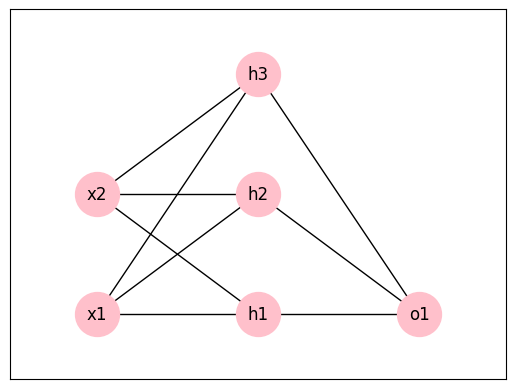

In [10]:
nx.draw_networkx(G, pos=nodePos,
                 node_size=1000, node_color='pink')
plt.margins(0.2, 0.2)

#### Including a bias term

We will also add a *bias node* at each layer. This simplifies the computation of weights by adding an extra input whose value is always 1. The bias term then comes from the weight applied to that input.

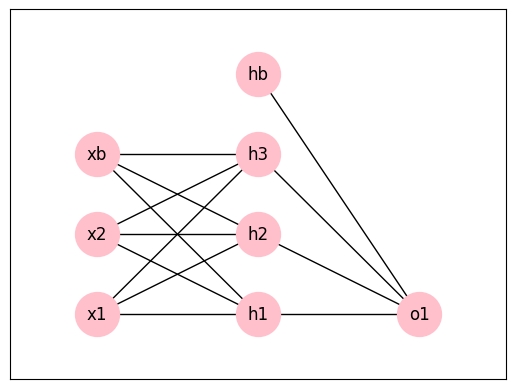

In [11]:
nodePos['xb']=(1, inputLayerSize)
G.add_node('xb')
for n in range(hiddenLayerSize):
  G.add_edge('xb', 'h' + str(n+1))

nodePos['hb']=(3, hiddenLayerSize)
G.add_node('hb')
for n in range(outputLayerSize):
  G.add_edge('hb', 'o' + str(n+1))

nx.draw_networkx(G, pos=nodePos,
                 node_size=1000, node_color='pink')
plt.margins(0.2, 0.2)

We will augment the data to add the bias “feature” $x_b$, whose value is always a 1:

In [12]:
X_train_aug = np.column_stack((np.ones((X_train.shape[0],1)), X_train))
X_train_aug

array([[1.        , 0.82410423, 0.50367647],
       [1.        , 0.86319218, 0.63602941],
       [1.        , 0.57003257, 0.53676471],
       [1.        , 0.53094463, 0.23897059],
       [1.        , 0.80456026, 1.        ],
       [1.        , 0.68729642, 0.73529412],
       [1.        , 0.94136808, 0.90073529],
       [1.        , 0.78501629, 0.93382353],
       [1.        , 0.80456026, 0.56985294],
       [1.        , 0.86319218, 0.53676471],
       [1.        , 1.        , 0.4375    ],
       [1.        , 0.64820847, 0.27205882],
       [1.        , 0.4723127 , 1.        ],
       [1.        , 0.96091205, 1.        ],
       [1.        , 0.94136808, 0.80147059]])

In [13]:
X_test_aug = np.hstack((np.ones((X_test.shape[0],1)), X_test))
X_test_aug

array([[1.        , 0.5504886 , 0.30514706],
       [1.        , 0.96091205, 0.50367647],
       [1.        , 0.49185668, 0.17279412],
       [1.        , 0.78501629, 0.23897059],
       [1.        , 0.96091205, 0.47058824],
       [1.        , 0.4723127 , 0.60294118],
       [1.        , 0.57003257, 0.17279412],
       [1.        , 1.01954397, 0.10661765],
       [1.        , 0.5504886 , 0.10661765],
       [1.        , 1.01954397, 0.60294118],
       [1.        , 0.94136808, 0.10661765],
       [1.        , 0.66775244, 0.10661765],
       [1.        , 0.86319218, 0.13970588],
       [1.        , 0.78501629, 0.50367647],
       [1.        , 0.88273616, 0.76838235]])

#### Defining inputs and outputs in the network

Next, we will define the input and output at each node in the network.

At every node in the hidden layer, the input to the activation function is the weighted sum of inputs to the node:

$$z_j = \sum_i w_{j,i} x_i$$

including the intput from the bias node $x_b$, which is always 1.

The output of a hidden node is the output of an activation function applied to that weighted sum of inputs. We will use a sigmoid activation function:

$$u_H = g_{H}(z_H) = \sigma(z_H) = \frac{1}{1 + e^{-z_H}}$$

In [14]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In the output layer, we use the weighted sum of inputs to the node from the hidden layer (i.e. weighted sum of each $u_i$ from hidden node $i$):

$$z_j = \sum_i w_{j,i} u_i$$

including one $u_{hb}$ from the hidden layer bias node, which always outputs a 1.

Then, since this is a regression problem, at the output layer we will use the identity function on $z_O$ to get the final output $u_O$:

$$\hat{y} = u_O = g_{O}(z_O)=z_O$$

#### Summary of network variables and dimensions

The table below summarizes the variables in the network, and their dimensions.

| Code Symbol | Math Symbol |             Definition              |     Dimensions     |
|:-----------:|:-----------:|:-----------------------------------:|:------------------:|
|     `X`     |    $$X$$    | Training data, each row is a sample |  ($N$, $N_I$ + 1)  |
|     `y`     |    $$y$$    |       Labels of training data       |    ($N$, $N_O$)    |
|    `W_H`    |  $$W_{H}$$  |        Hidden layer weights         | ($N_I + 1$, $N_H$) |
|    `W_O`    |  $$W_{O}$$  |        Output layer weights         | ($N_H + 1$, $N_O$) |
|    `z_H`    |  $$z_{H}$$  |  Input to hidden layer activation   |    ($N$, $N_H$)    |
|    `u_H`    |  $$u_{H}$$  |  Output of hidden layer activation  |    ($N$, $N_H$)    |
|    `z_O`    |  $$z_{O}$$  |  Input to output layer activation   |    ($N$, $N_O$)    |
|    `u_O`    |  $$u_{O}$$  |  Output of output layer activation  |    ($N$, $N_O$)    |

where for this problem $N=15$, $N_I = 2$, $N_O = 1$, $N_H = 3$.

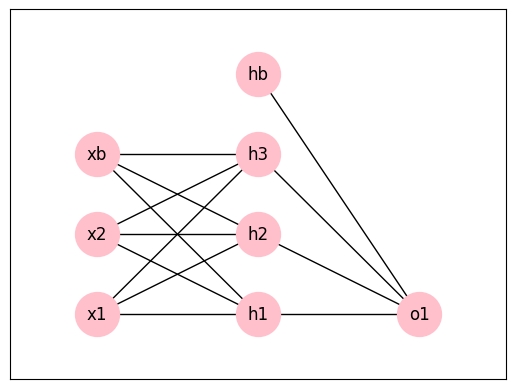

In [15]:
nx.draw_networkx(G, pos=nodePos,
                 node_size=1000, node_color='pink')
plt.margins(0.2, 0.2)

#### Initialize weights

To start, we will initialize all weights to random values:

In [16]:
np.random.seed(9)
W_H = np.random.randn(inputLayerSize+1, hiddenLayerSize)
W_O = np.random.randn(hiddenLayerSize+1, outputLayerSize)
# the extra 1 is because of the bias nodes

In [17]:
W_H

array([[ 1.10855471e-03, -2.89544069e-01, -1.11606630e+00],
       [-1.28827567e-02, -3.78361464e-01, -4.81135363e-01],
       [-1.51733118e+00, -4.90871981e-01, -2.40680579e-01]])

In [18]:
W_O

array([[-0.64794746],
       [ 0.63589108],
       [ 1.74011731],
       [ 0.29668222]])

### Feed values forward

To start training our neural network, we will feed the training values through the network and observe the output. This is known as the “forward pass”.

#### Computations in the forward pass

In the forward pass, we proceed through the computation graph from the input to the output. At each stage, we will compute a function of the output of the previous stage.

First, we will compute the linear transform on the inputs, using the current weights at the hidden layer:

$$z_H =  W_H^T X $$

Then, we will use $z_H$ and apply the activation function at the hidden layer:

$$u_H = g_{H}(z_H)$$

The next step is to compute the linear transform at the output layer, using $u_H$ as input:

$$z_O =  W_O^T [1, u_H] $$

Finally, we use $z_O$ and compute the response function at the output:

$$u_O = g_{O}(z_O)  $$

We will save $z_H$, $u_H$, $z_O$, and $u_O$ in each iteration, since these values will be used to compute the gradient in the backward pass.

In [19]:
# feed inputs though network
def forward(X, W_H, W_O):
    # linear transform at input to hidden layer
    z_H = np.dot(X, W_H)
    # activation function at hidden layer
    u_H = sigmoid(z_H)
    # add an extra "ones" column for the bias term at the output layer
    u_H_b = np.column_stack((np.ones((u_H.shape[0],1)), u_H))
    # linear transform at input to output layer
    z_O = np.dot(u_H_b, W_O)
    # output function
    u_O = z_O
    return z_H, u_H, z_O, u_O

#### Execution of first forward pass

We are ready to execute the first forward pass.

With our initial random weights, the output of the network on the training set is:

In [20]:
z_H, u_H, z_O, u_O = forward(X_train_aug, W_H, W_O)
y_hat = u_O
y_hat

array([[ 0.12279609],
       [ 0.06554042],
       [ 0.15085488],
       [ 0.28295323],
       [-0.05075003],
       [ 0.05617215],
       [-0.03875054],
       [-0.02686829],
       [ 0.09991683],
       [ 0.10355795],
       [ 0.12143676],
       [ 0.24826956],
       [-0.00143411],
       [-0.07283925],
       [-0.00559937]])

#### Computing loss

With our first set of predictions in hand, we can compute the loss function for this network. Since this is a regression problem, we will use the mean squared error loss function. For $N$ input samples,

$$L(W) = \frac{1}{2}\sum_N (y_i - u_{Oi})^2$$

where $W = (W_H, W_O)$.

(The $\frac{1}{2}$ factor in front is for convenience, so that when we compute the derivative in order to do gradient descent, we won’t have to carry a $2$ factor with us throughout our computations.)

In [21]:
def loss_function(y_true, y_hat):
    # compute loss function for a given prediction
    return 0.5*np.sum((y_true-y_hat)**2, axis=0)

Then the training loss of our network for this training set, using the initial random weights, is:

In [22]:
l=loss_function(y_train, y_hat)
print(l)

[3.52260967]


### Propagate error backwards

To update the weights in our neural network, we will use gradient descent to move in the direction of steepest (infinitesimal) decrease in our loss function. We will therefore need to compute the gradient of the loss function with respect to each weight: $\frac{\partial L(W)}{\partial W}$.

Backpropagation is an iterative procedure for efficient computation of gradients using the chain rule. In backpropagation, we compute gradients starting from the output of the network, and work our way back towards the inputs.

#### Digression: chain rule on a computational graph

Suppose we have a computational graph, representing the composite function $f(g(h(x)))$.

To compute the output, we do a *forward pass* on the computational graph:

<figure>
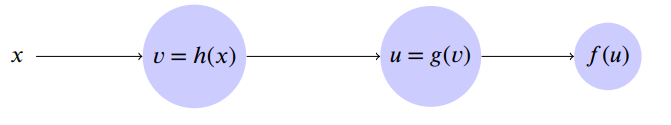
<figcaption aria-hidden="true">image.png</figcaption>
</figure>

To compute the derivative via chain rule, we do a *backward pass* on the computational graph, where we get the derivative of each node with respect to its inputs.

<figure>
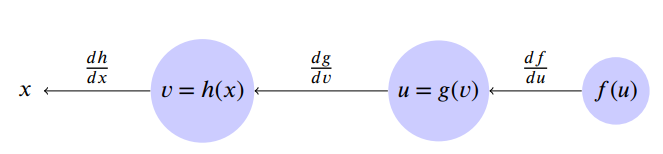
<figcaption aria-hidden="true">image.png</figcaption>
</figure>

We will use a similar method to train our neural network.

We will execute the backpropagation algorithm on our neural network as follows:

**Step 1**: Apply input (or batch of inputs) to network and propagate values forward. (Sum is over all inputs to node $j$)

$$z_j = \sum_i w_{j,i} u_i, \quad u_j = g(z_j)$$

**Step 2**: Evaluate $\delta_k = \frac{\delta L}{\delta z_k}$ for all output units.

For a regression network with a linear activation function at the output nodes, $\delta_k = \frac{\partial L}{\partial z_k} = -(y_n - z_{k})$

**Step 3**: For each hidden unit, we we “backpropagate” the $\delta$s from all outputs of a hidden unit to get $\delta_j$ for that hidden unit. (Sum is over all outputs of node $j$)

$$
\begin{aligned}
\delta_j & = \frac{\delta L}{\delta z_j} \\
 & = \sum_k \frac{\delta L}{\delta z_k}\frac{\delta z_k}{\delta z_j} \\
 & = \sum_k  \delta_k \frac{\delta z_k}{\delta z_j} \\
 & = \sum_k  \delta_k w_{k,j} g'(z_j) \\
 & = g'(z_j) \sum_k w_{k,j} \delta_k
\end{aligned}
$$

**Step 4**: Use $\frac{\partial L_n}{\partial w_{j,i}} = \delta_j u_i$ to evaluate derivatives with respect to weights at all nodes.

<figure>
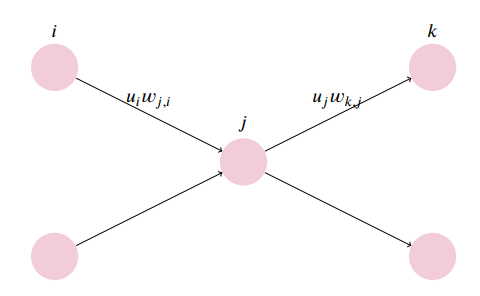
<figcaption aria-hidden="true">image.png</figcaption>
</figure>

We are using a sigmoid activation function at the hidden units, so we will write a function `sigmoidPrime` to compute the derivative of a sigmoid with respect to its input.

In [23]:
def sigmoidPrime(z):
    # derivative of sigmoid function
    return np.exp(-z)/((1+np.exp(-z))**2)

Finally, we can write our `backprop` function:

In [24]:
def backprop(X, y, W_H, W_O, z_H, u_H, z_O, u_O):
    # compute backpropagation error at output layer
    deltaO = -(y-z_O)

    # compute backpropagation error at hidden layer
    # (note that we don't propagate back error of bias node)
    deltaH = np.dot(deltaO, W_O[1:hiddenLayerSize+1].T)*sigmoidPrime(z_H)

    # compute derivative w.r.t. weights at output layer
    u_H_b = np.column_stack((np.ones((u_H.shape[0],1)), u_H))
    dLdwO = np.dot(u_H_b.T, deltaO).reshape(hiddenLayerSize+1,outputLayerSize)

    # compute derivative w.r.t. weights at hidden layer
    dLdwH = np.dot(X.T, deltaH)
    # return derivatives
    return dLdwO, dLdwH

In [25]:
dLdwO, dLdwH = backprop(X_train_aug, y_train, W_H, W_O, z_H, u_H, z_O, u_O)

In [26]:
print(dLdwO)
print(dLdwH)

[[-9.09566587]
 [-2.19214132]
 [-2.47487746]
 [-1.39665172]]
[[-1.03990459 -3.12814644 -0.35050278]
 [-0.88510364 -2.64996514 -0.296022  ]
 [-0.76317137 -2.36740073 -0.26625607]]


In [27]:
print(W_H)
print(W_O)

[[ 1.10855471e-03 -2.89544069e-01 -1.11606630e+00]
 [-1.28827567e-02 -3.78361464e-01 -4.81135363e-01]
 [-1.51733118e+00 -4.90871981e-01 -2.40680579e-01]]
[[-0.64794746]
 [ 0.63589108]
 [ 1.74011731]
 [ 0.29668222]]


### Apply gradient descent

Now that we have computed the gradient of the loss function with respect to each weight, we can use gradient descent. The gradient points towards the direction of greatest (infinitesimal) increase, so we will move each weight in the opposite direction.

In [28]:
learningRate = 0.01
W_H = W_H - learningRate*dLdwH
W_O = W_O - learningRate*dLdwO

After we complete another forward pass and compute loss for the new weights, we can see that the loss has decreased.

In [29]:
z_H, u_H, z_O, u_O = forward(X_train_aug, W_H, W_O)
l_new = loss_function(y_train, u_O)
print(l, l_new)

[3.52260967] [2.44151428]


### Iterate

To train our network, we will repeat this procedure for some number of *epochs*.

In [30]:
epochs = 1000
y_hat = np.zeros((epochs, y_train.shape[0], y_train.shape[1]))
L_train = np.zeros(epochs)
L_test = np.zeros(epochs)

In [31]:
learningRate = 0.05
np.random.seed(321)

W_H_init = np.random.randn(inputLayerSize+1, hiddenLayerSize)
W_O_init = np.random.randn(hiddenLayerSize+1, outputLayerSize)

W_H = W_H_init
W_O = W_O_init

for e in range(epochs):

  # get loss on test set
  # this is not used to update weights,
  # we only do this for visualization
  z_H, u_H, z_O, u_O = forward(X_test_aug, W_H, W_O)
  L_test[e] = loss_function(y_test, u_O)

  # forward pass for this epoch
  z_H, u_H, z_O, u_O = forward(X_train_aug, W_H, W_O)
  # get loss on training set
  L_train[e] = loss_function(y_train, u_O)
  y_hat[e] = u_O

  # backward pass for this epoch
  dLdwO, dLdwH = backprop(X_train_aug, y_train, W_H, W_O, z_H, u_H, z_O, u_O)
  # gradient descent
  W_H = W_H - learningRate*dLdwH
  W_O = W_O - learningRate*dLdwO

C:\Users\cj\AppData\Local\Temp\ipykernel_9600\3939375717.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L_test[e] = loss_function(y_test, u_O)
C:\Users\cj\AppData\Local\Temp\ipykernel_9600\3939375717.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L_train[e] = loss_function(y_train, u_O)


Finally, we will visualize the performance of the network as it trains.

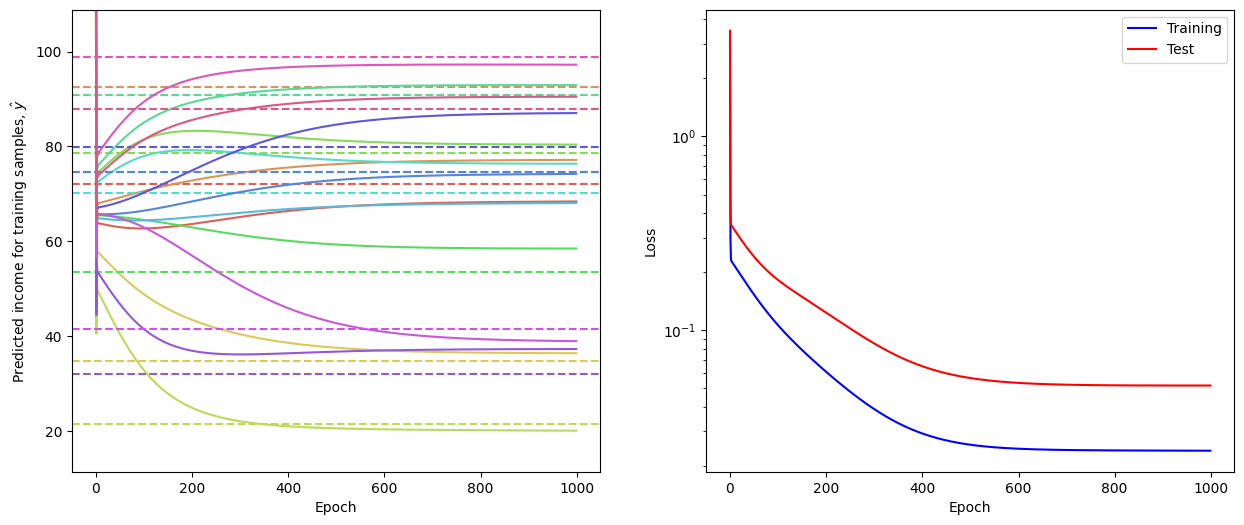

In [32]:
# plot output values vs iterations
colors = sns.color_palette("hls", y_train.shape[0])
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.ylim(np.amin(y_train*y_max)-10, np.amax(y_train*y_max)+10)
for n in range(y_train.shape[0]):
  plt.axhline(y=y_max*y_train[n], linestyle='--', color=colors[n])
  sns.lineplot(x=np.arange(0, epochs), y=y_max*y_hat[:,n].ravel(), color=colors[n])
plt.xlabel("Epoch");
plt.ylabel("Predicted income for training samples, $\hat{y}$");

plt.subplot(122)
p = sns.lineplot(x=np.arange(0, epochs), y=L_train, color='blue', label='Training')
p = sns.lineplot(x=np.arange(0, epochs), y=L_test, color='red', label='Test')
p.set(yscale="log")
plt.xlabel("Epoch");
plt.ylabel("Loss");

### Analyze results

Here is a plot of true vs. predicted values, for the training and test data:

In [33]:
z_H, u_H, z_O, u_O = forward(X_train_aug, W_H, W_O)
y_pred_train = u_O[:,0]
z_H, u_H, z_O, u_O = forward(X_test_aug, W_H, W_O)
y_pred_test = u_O[:,0]

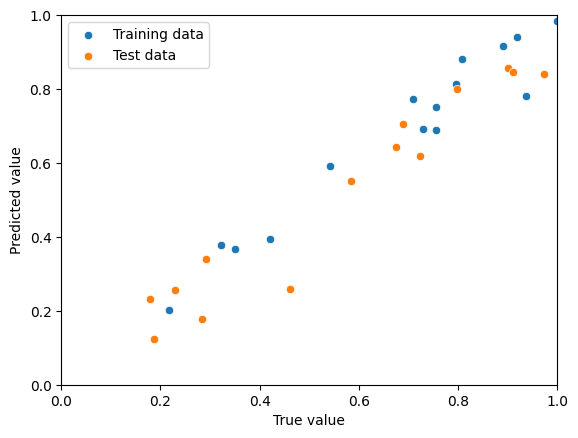

In [34]:
sns.scatterplot(x=y_train[:,0], y = y_pred_train, label='Training data');
sns.scatterplot(x=y_test[:,0], y = y_pred_test, label='Test data');
plt.xlim(0,1);
plt.ylim(0,1);
plt.xlabel('True value');
plt.ylabel('Predicted value');

(a perfect regression result would be the diagonal line $y=x$.)